# Benchmark de Modelos (Arena de Comparação)

**Objetivo:** Comparar diferentes algoritmos de Machine Learning para definir qual performa melhor em cada segmento de crédito (PF, PJ, Rural).

**Os Competidores:**
1.  **Ridge Regression (Linear):** O baseline. Bom para detectar tendências lineares simples e evitar overfitting extremo.
2.  **Random Forest (Ensemble):** O campeão atual. Robusto, lida bem com não-linearidades e interações entre variáveis.
3.  **XGBoost (Boosting):** O estado da arte em dados tabulares. Foca nos erros dos modelos anteriores para melhorar a precisão.

**Estratégia:**
Manteremos a abordagem de **Previsão de Delta (Variação)** para garantir compatibilidade com o simulador (App).

In [1]:
# --- 1. Configuração e Imports ---
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Algoritmos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

# Métricas e Processamento
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import clone

# Configuração Visual
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Caminhos
path_data = Path("../data/processed/df_modelagem_v3.csv")
path_models = Path("../models/")
path_models.mkdir(parents=True, exist_ok=True)

# Carregar Dados
if path_data.exists():
    df = pd.read_csv(path_data, index_col="data", parse_dates=True)
    print(f"Dados carregados. Shape: {df.shape}")
else:
    raise FileNotFoundError("Base de dados não encontrada.")

Dados carregados. Shape: (120, 50)


In [2]:
# --- 2. Definição dos Competidores e Alvos ---

# Dicionário de Algoritmos
modelos_config = {
    "Ridge": Ridge(alpha=10.0), # Alpha alto = modelo mais conservador
    "RandomForest": RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
}

# Dicionário de Alvos (Targets)
# Verificamos quais colunas existem no DF
targets_map = {
    "PF": "inad_pf_tot",
    "PJ": "inad_pj_tot",
    "Rural_PF": "inad_rd_pf_cr_rur_tot",  
    "Rural_PJ": "inad_rd_pj_cr_rur_tot"   
}
targets = {k: v for k, v in targets_map.items() if v in df.columns}

# DataFrame para guardar os resultados (Placar Final)
resultados = []

print(f"Segmentos a processar: {list(targets.keys())}")
print(f"Algoritmos na disputa: {list(modelos_config.keys())}")

Segmentos a processar: ['PF', 'PJ', 'Rural_PF', 'Rural_PJ']
Algoritmos na disputa: ['Ridge', 'RandomForest', 'XGBoost']


# O Loop de Treinamento e Validação

In [3]:
# --- 3. Execução da Arena ---

cols_leakage_base = [c for c in df.columns if c.startswith("inad_")]

for segmento, target_col in targets.items():
    print(f"\n--- 🏁 Iniciando Rodada: {segmento} ---")
    
    # --- A. Preparação dos Dados (Igual ao notebook 05) ---
    df_temp = df.copy()
    
    # Target: Delta (Variação)
    df_temp["target_delta"] = df_temp[target_col].diff()
    
    # Feature: Lag (Valor Anterior)
    df_temp["valor_anterior"] = df_temp[target_col].shift(1)
    
    df_temp = df_temp.dropna()
    
    # X e y
    y = df_temp["target_delta"]
    
    # Remove Leakage (outras inadimplências) e Target atual
    X = df_temp.drop(columns=cols_leakage_base + ["target_delta"])
    
    # Reinsere o Lag permitido
    X["inad_anterior"] = df_temp["valor_anterior"]
    
    # Dummies e Scale
    X = pd.get_dummies(X, drop_first=True)
    
    # Divisão Treino/Teste para Validação (80/20 Cronológico)
    # Precisamos disso para saber quem ganhou
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Scaler (Fit no treino apenas)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Salvar artefatos globais do segmento (Scaler e Colunas)
    # Salvamos o scaler treinado na base toda depois, mas aqui salvamos o de teste para garantir
    joblib.dump(scaler, path_models / f"scaler_{segmento}_full.pkl") 
    pd.DataFrame(columns=X.columns).to_csv(path_models / f"columns_{segmento}_full.csv", index=False)
    
    # Metadados (Último valor real para o App)
    meta = {
        "data_referencia": df.index[-1],
        "valor_ultimo_real": df.iloc[-1][target_col],
        "X_ultimo_real": X.iloc[-1].to_dict()
    }
    joblib.dump(meta, path_models / f"meta_{segmento}_full.pkl")

    # --- B. Batalha dos Modelos ---
    
    melhor_rmse = float("inf")
    melhor_modelo_nome = ""
    
    for nome_algo, modelo_base in modelos_config.items():
        # 1. Clonar e Treinar
        model = clone(modelo_base)
        model.fit(X_train_scaled, y_train)
        
        # 2. Prever (No conjunto de teste)
        y_pred = model.predict(X_test_scaled)
        
        # 3. Calcular Erro
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        # Guardar no Placar
        resultados.append({
            "Segmento": segmento,
            "Modelo": nome_algo,
            "RMSE": rmse,
            "MAE": mae
        })
        
        print(f"   > {nome_algo.ljust(15)} | RMSE: {rmse:.4f}")
        
        # Se for o melhor até agora, salvamos como o oficial "model_{segmento}.pkl"
        # Assim o App sempre pega o campeão automaticamente
        if rmse < melhor_rmse:
            melhor_rmse = rmse
            melhor_modelo_nome = nome_algo
            
            # Re-treinar na base COMPLETA (Treino + Teste) para produção
            scaler_full = StandardScaler()
            X_full_scaled = scaler_full.fit_transform(X) # X total
            
            model_prod = clone(modelo_base)
            model_prod.fit(X_full_scaled, y)
            
            # Salvar como o modelo oficial
            joblib.dump(model_prod, path_models / f"model_{segmento}_full.pkl")
            joblib.dump(scaler_full, path_models / f"scaler_{segmento}_full.pkl") # Atualiza scaler oficial

    print(f"🏆 VENCEDOR {segmento}: {melhor_modelo_nome} (Salvo para o App)\n")


--- 🏁 Iniciando Rodada: PF ---
   > Ridge           | RMSE: 0.0505
   > RandomForest    | RMSE: 0.0661
   > XGBoost         | RMSE: 0.0934
🏆 VENCEDOR PF: Ridge (Salvo para o App)


--- 🏁 Iniciando Rodada: PJ ---
   > Ridge           | RMSE: 0.0787
   > RandomForest    | RMSE: 0.0647
   > XGBoost         | RMSE: 0.1343
🏆 VENCEDOR PJ: RandomForest (Salvo para o App)


--- 🏁 Iniciando Rodada: Rural_PF ---
   > Ridge           | RMSE: 0.1373
   > RandomForest    | RMSE: 0.0982
   > XGBoost         | RMSE: 0.0978
🏆 VENCEDOR Rural_PF: XGBoost (Salvo para o App)


--- 🏁 Iniciando Rodada: Rural_PJ ---
   > Ridge           | RMSE: 0.2234
   > RandomForest    | RMSE: 0.1636
   > XGBoost         | RMSE: 0.0794
🏆 VENCEDOR Rural_PJ: XGBoost (Salvo para o App)



# Análise dos Resultados


--- Tabela de Erros (RMSE - Menor é melhor) ---


Modelo,RandomForest,Ridge,XGBoost
Segmento,,,
PF,0.066068,0.050482,0.093412
PJ,0.064734,0.078712,0.134288
Rural_PF,0.098220,0.137256,0.097785
Rural_PJ,0.163587,0.223403,0.079357


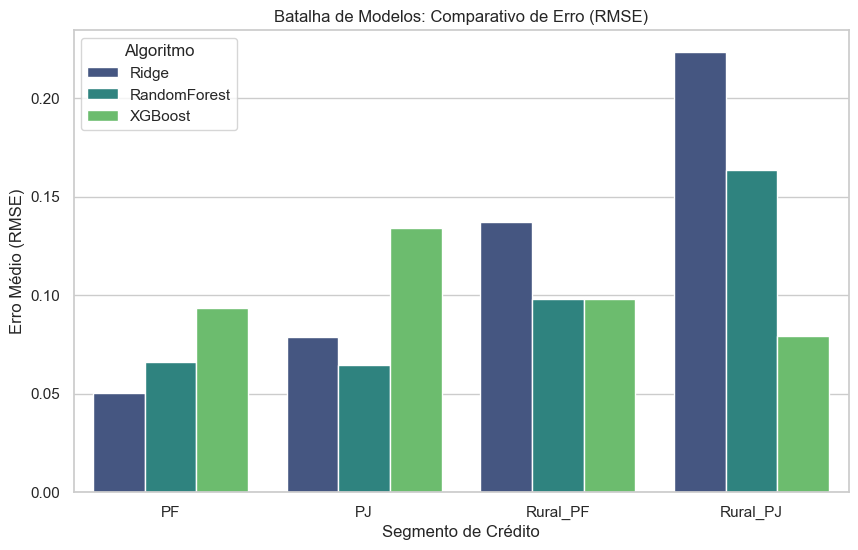

In [4]:
# --- 4. Visualização do Placar Final ---

df_resultados = pd.DataFrame(resultados)

# Pivotar para facilitar comparação visual
pivot_rmse = df_resultados.pivot(index="Segmento", columns="Modelo", values="RMSE")

print("\n--- Tabela de Erros (RMSE - Menor é melhor) ---")
display(pivot_rmse.style.highlight_min(axis=1, color='lightgreen'))

# Gráfico de Barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados, x="Segmento", y="RMSE", hue="Modelo", palette="viridis")
plt.title("Batalha de Modelos: Comparativo de Erro (RMSE)")
plt.ylabel("Erro Médio (RMSE)")
plt.xlabel("Segmento de Crédito")
plt.legend(title="Algoritmo")
plt.show()

### Conclusão e Próximos Passos

O código acima não apenas comparou os modelos, mas implementou uma lógica de **Auto-Seleção**:
1. Ele testou Ridge, Random Forest e XGBoost em uma divisão de tempo (Passado vs Futuro Recente).
2. Identificou qual teve o menor erro.
3. **Re-treinou o vencedor** usando todos os dados disponíveis.
4. Salvou o vencedor com o nome padrão `model_PF.pkl` (ou PJ, Rural).

Isso significa que você não precisa alterar o `app.py`. O App vai carregar automaticamente o melhor modelo que este notebook encontrou.